Accomodation 

Caleb Haynes 2/3/2020 for Johanna Jarcho 

This converts data output by a delayed discounting task presented in E-Prime. 

Conversion reformatting for input to hBayesDM R package - dd_hyperbolic.

https://rdrr.io/cran/hBayesDM/man/dd_hyperbolic.html

Requirements:

subjID
A unique identifier for each subject in the data-set.

delay_later
An integer representing the delayed days for the later option (e.g. 1, 6, 28).

amount_later
A floating point number representing the amount for the later option (e.g. 10.5, 13.4, 30.9).

delay_sooner
An integer representing the delayed days for the sooner option (e.g. 0).

amount_sooner
A floating point number representing the amount for the sooner option (e.g. 10).

choice
If amount_later was selected, choice == 1; else if amount_sooner was selected, choice == 0.


In [1]:
import pandas as pd
import numpy as np
import glob


In [2]:
'''
find all converted .edat2 -> xlsx in data directory
'''
accom_dfs = [pd.read_excel(i) for i in glob.glob("data/s*_1/DD_*.xlsx")]

In [3]:
for df in accom_dfs:
    subno = df['Subject'][1]
    #drop practice rows
    df = df.drop(df.index[0:2])
    
    '''
    renaming columns to match R package standards. 
    DelR and AmtR always have larger values, variable/column LeftRight
    determines if it will be placed on Left or Right side of screen for
    counterbalancing. Higher value is also always 'delayed' option, so 
    we can rename those columns to fit standard. Opposite for smaller 
    values which will always be in DelL and AmtL.
    '''
    df = df.rename(columns={'Subject': 'subjID', 
                            'DelR': 'delay_later',
                            'DelL': 'delay_sooner',
                            'AmtR': 'amount_later',
                            'AmtL': 'amount_sooner'})
    
    '''
    Delay Soon is always 'now,' so we need to change all to 0
    '''
    df = df.replace(df[['delay_sooner']], 0)
    
    '''
    get rid of empty rows
    
    '''
    df = df.dropna(subset=['Amount14.RESP', 'Amount6.RESP'])
    
 
    
    '''
    Choice is more complex- 
    If LeftRight == 0, then Amount14 was shown on the right side of the screen, 
    if Amount14.RESP=='j'they chose what is on the right side of the screen.

    If LeftRight == 1, then Amount6 was shown on the right side of the screen, 
    f Amount6.RESP =='j, they chose the delayed reward, which was what appeared on the right side of the screen.  
    
    '''
    def label_displayed(row):
        if row['LeftRight'] == 0 and row['Amount14.RESP'] == 'j':
            return 0
        else:
            return 1
    df['choice'] = df.apply(lambda row: label_displayed(row), axis=1)
    
    hbayes_df = df[['subjID','delay_later','amount_later','delay_sooner','amount_sooner','choice']]
    
    #write df to tsv
    hbayes_df.to_csv('data/s{}_1/DD_{}.tsv'.format(subno, subno), index = False, sep = '\t')

In [4]:
'''
Now I need to join all output tsvs from above into one merged 
'''
accom_dfs = [pd.read_csv(i, sep = '\t') for i in glob.glob("data/s*_1/DD_*.tsv")]
merged = pd.concat(accom_dfs)
merged.to_csv('accom_merged.txt', index=False, sep = '\t')

In [5]:
df = pd.read_csv('accom_merged.txt', sep='\t')
from hbayesdm import rhat, print_fit
from hbayesdm.models import dd_hyperbolic

https://hbayesdm.readthedocs.io/en/v1.0.1/models.html#id224
Delay Discounting Task - Hyperbolic Model

Hierarchical Bayesian Modeling of the Delay Discounting Task using Hyperbolic Model [Mazur1987] with the following parameters: “k” (discounting rate), “beta” (inverse temperature).

[Mazur1987]	Mazur, J. E. (1987). An adjustment procedure for studying delayed reinforcement.


In [6]:
output = dd_hyperbolic(data=df, niter=2000, nwarmup=1000, nchain=4, ncore=4)

Using cached StanModel: cached-dd_hyperbolic-pystan_2.19.1.1.pkl



Model  = dd_hyperbolic
Data   = <pandas.DataFrame object>

Details:
 # of chains                    = 4
 # of cores used                = 4
 # of MCMC samples (per chain)  = 2000
 # of burn-in samples           = 1000
 # of subjects                  = 68
 # of (max) trials per subject  = 50

Using cached StanModel: cached-dd_hyperbolic-pystan_2.19.1.1.pkl
Index(['subjid', 'delaylater', 'amountlater', 'delaysooner', 'amountsooner',
       'choice'],
      dtype='object')
['subjID', 'delay_later', 'amount_later', 'delay_sooner', 'amount_sooner', 'choice']
************************************
**** Model fitting is complete! ****
************************************


/home/tul67061/.local/lib/python3.5/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/tul67061/.local/lib/python3.5/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


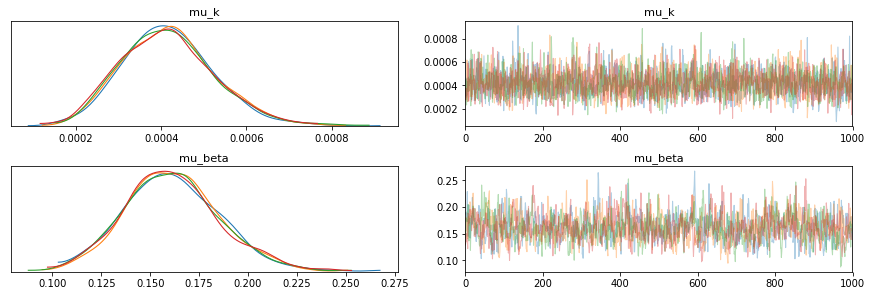

In [7]:
output.plot(type='trace')

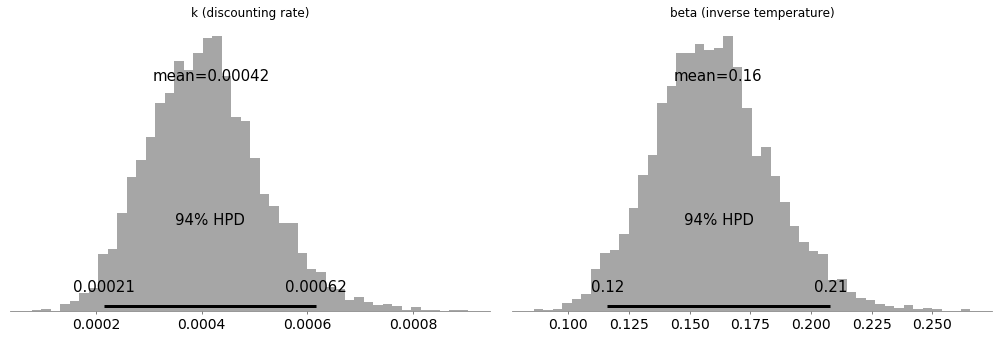

In [8]:
output.plot()

In [9]:
rhat(output, less=1.1)

{'beta': True,
 'k': True,
 'log_lik': True,
 'mu_beta': True,
 'mu_k': True,
 'sigma': True}

In [10]:
print_fit(output)

/home/tul67061/.local/lib/python3.5/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
dd_hyperbolic,0,3428.96,72.1408,0,1,123.287,0,True,deviance
